In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir("/content/drive/MyDrive")
!ls

In [ ]:
cd /content/drive/MyDrive

In [1]:
###################3 start from here ###########################3

import numpy as np
images = np.load ('images_1.npy')
masks = np.load ('masks_1.npy')

In [2]:
print(images.shape)
print(masks.shape)

(1, 32550, 128, 128)
(1, 32550, 128, 128)


In [3]:
labels=np.append(np.zeros(14079),np.ones(18471))
print(labels.shape)

(32550,)


In [4]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [5]:
images = np.expand_dims(images.squeeze(), -1)  

In [6]:
masks = np.expand_dims(masks.squeeze(), -1)  

In [7]:
print(images.shape)
print(masks.shape)

(32550, 128, 128, 1)
(32550, 128, 128, 1)


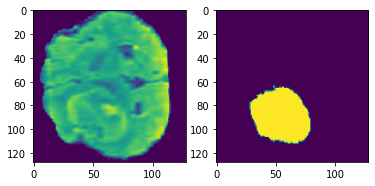

In [8]:
####################  not required ##################################

import matplotlib.pyplot as plt
img_index = 100
plt.subplot(1,2,1)
plt.imshow(images[100])
plt.subplot(1,2,2)
plt.imshow(masks[100])

In [9]:
from keras.utils import np_utils
labels=np_utils.to_categorical(labels)

Using TensorFlow backend.


In [10]:
labels.shape

(32550, 2)

In [11]:
from scipy.io import loadmat
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import keras

import pandas as pd
import numpy as np

from os.path import join

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.display import clear_output

from datetime import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta



from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection =K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)



In [12]:
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.utils import plot_model



In [13]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as Keras

#from tensorflow.keras import backend as Keras

from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection =K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


pretrained_weights = None
input_size = (128,128,1)
inputTensor = Input(input_size,name='input')
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputTensor)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
bn=BatchNormalization()(conv1)  ######### batch normalization
pool1 = MaxPooling2D(pool_size=(2, 2))(bn)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
bn1=BatchNormalization()(conv2)   ######### batch normalization
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
bn2=BatchNormalization()(conv3)      ######### batch normalization
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
bn3=BatchNormalization()(conv4)      ######### batch normalization
drop4 = Dropout(0.5)(bn3)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
#Decoder path
conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
bn4=BatchNormalization()(conv5)     ######### batch normalization
drop5 = Dropout(0.5)(bn4)

up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
bn5=BatchNormalization()(conv6)     ######### batch normalization

up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn5))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
bn6=BatchNormalization()(conv7)       ######### batch normalization

up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn6))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
bn7=BatchNormalization()(conv8)        ######### batch normalization

up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn7))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
segmentation_output = Conv2D(1, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal',name='segmentation')(conv9)
#bn8=BatchNormalization()(conv10)       ######### batch normalization
#segmentation_output = Conv2D(1,1, activation='softmax',name='segmentation')(bn8)
				

## Keras Functional API
- This is the main branch
- These layers are common to both the tasks


- This is where the network branches for multiple outputs/tasks
- gender is n x 2 output where as age is n x 1 output

In [14]:
dense_classification=Flatten()(pool4)
dense_classification=Dense(300)(dense_classification)
classification_output = Dense(2, activation='softmax', name='classification')(dense_classification)
# segmentation_output = Conv2D(1,1, activation='softmax',name='segmentation')(bn8)

In [15]:
model = Model(inputs = inputTensor,
     outputs = [classification_output, segmentation_output])
#      outputs = [segmentation_output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
#from keras.utils.vis_utils import plot_model
3plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Multi loss optimizations

- mse for age and cross-entropy for gender
- we can weight these individual losses
- Loss = weight1 * loss1 + weight2 * loss2

In [16]:
import tensorflow.keras

#lr_schedule =tensorflow.keras.optimizers.schedules.ExponentialDecay(
#                                                                    initial_learning_rate=0.001,
#                                                                    decay_steps=10000,
 #                                                                   decay_rate=0.9,
 #                                                                   starircase = true)

#redcue learning rate
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)



 
# checkpoint
filepath="D:/maria/weights-improvement-{epoch:02d}-{val_segmentation_dice_coef:.2f}.hdf5"
checkpoint_cp = ModelCheckpoint(filepath, monitor='val_segmentation_dice_coef', verbose=1, save_best_only=True, mode='max')


#opt = tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule)
opt = tensorflow.keras.optimizers.RMSprop()
model.compile(optimizer=opt,
              loss={'classification': 'categorical_crossentropy', 'segmentation': dice_coef_loss },
              loss_weights={'classification': 0.001, 'segmentation': 0.1},
              metrics=['accuracy', dice_coef])
# model.compile(optimizer=opt,
#               loss={'segmentation': dice_coef_loss },
#               metrics=['accuracy', dice_coef])

In [17]:
images_train,images_test, labels_train, labels_test,masks_train, masks_test = train_test_split(images,labels,masks, test_size=.2, 
                                                   random_state=222, 
                                                   shuffle=True, stratify=None)

In [18]:
print(images_train.shape)
print(images_test.shape)
print(labels_train.shape)
print(labels_test.shape)
print(masks_train.shape)
print(masks_test.shape)

(26040, 128, 128, 1)
(6510, 128, 128, 1)
(26040, 2)
(6510, 2)
(26040, 128, 128, 1)
(6510, 128, 128, 1)


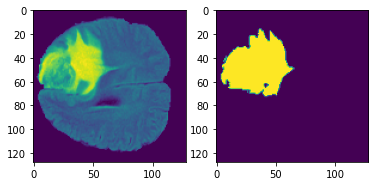

In [19]:
####################  not required ##################################

import matplotlib.pyplot as plt
img_index = 9
plt.subplot(1,2,1)
plt.imshow(images_train[img_index])
plt.subplot(1,2,2)
plt.imshow(masks_train[img_index])

In [20]:
labels_train[0:20]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:

try:
    
    history = model.fit({'input': images_train}, {'classification': labels_train, 'segmentation': masks_train},
                        epochs=100, batch_size=32, verbose=1, validation_split=None,validation_data = [{'input': images_test}, {'classification': labels_test, 'segmentation': masks_test}] ,callbacks=[checkpoint_cp])   
#     history = model.fit({'input': images_train}, { 'segmentation': masks_train},
#                         epochs=10, batch_size=32, verbose=1, validation_split=None,validation_data = [{'input': images_test}, { 'segmentation': masks_test}] ,callbacks=[checkpoint_cp])   
    
except:
  print("An exception occurred")

Train on 26040 samples, validate on 6510 samples
Epoch 1/100
26016/26040 [============================>.] - ETA: 0s - loss: 0.0801 - classification_loss: 7.3173 - segmentation_loss: 0.7275 - classification_accuracy: 0.7258 - classification_dice_coef: 0.6913 - segmentation_accuracy: 0.9622 - segmentation_dice_coef: 0.2725
Epoch 00001: val_segmentation_dice_coef improved from -inf to 0.35299, saving model to D:/maria/weights-improvement-01-0.35.hdf5
26040/26040 [==============================] - 168s 6ms/sample - loss: 0.0800 - classification_loss: 7.3089 - segmentation_loss: 0.7270 - classification_accuracy: 0.7258 - classification_dice_coef: 0.6913 - segmentation_accuracy: 0.9622 - segmentation_dice_coef: 0.2730 - val_loss: 0.0653 - val_classification_loss: 0.5779 - val_segmentation_loss: 0.6470 - val_classification_accuracy: 0.7846 - val_classification_dice_coef: 0.7432 - val_segmentation_accuracy: 0.9145 - val_segmentation_dice_coef: 0.3530
Epoch 2/100
26016/26040 [==================

In [ ]:
model.save('Checked_RMSPROP_FIRST_OUT_model.h5')


In [ ]:
test_data = images[351]

In [ ]:
gt = labels[351]

In [ ]:
gt

In [ ]:
plt.imshow(test_data)

In [ ]:
test_data.shape

In [ ]:
#checkpoint_path = "training_1/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                # save_weights_only=True,
                                                 #verbose=1)
p=test_data.reshape(1,128,128,1)
prediction=model.predict(p)
prediction

In [ ]:
#!pip install tensorflow-estimator=2.1.0
seg_predicted=prediction[1]
_classes=seg_predicted.argmax(axis=-1)
print('classes',_classes.shape)
# _classes[_classes==3]=4
_classes=_classes.astype('uint8')
plt.imshow(_classes[0,:,:])


In [ ]:
seg_predicted.dtype

In [ ]:
plt.imshow(seg_predicted[0,:,:]*255,'gray')

In [ ]:
converted = seg_predicted.astype(np.uint8)

In [ ]:
converted = converted[0,:,:,0]*255

In [ ]:
plt.imshow(converted)

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['classification_accuracy'])
plt.plot(history.history['val_classification_accuracy'])
plt.title('Classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['classification_loss'])
plt.plot(history.history['val_classification_loss'])
plt.title('Classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for segmentation accuracy
plt.plot(history.history['segmentation_accuracy'])
plt.plot(history.history['val_segmentation_accuracy'])
plt.title('segmentation_accu')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for Dice_loss
plt.plot(history.history['segmentation_loss'])
plt.plot(history.history['val_segmentation_loss'])
plt.title('Dice loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(history.history['val_segmentation_loss'])

In [ ]:
masks_images.shape

In [ ]:
images.shape